In [2]:
import MOMIA as mo
import GEMATRIA as gem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit 

In [3]:
# instead of using line-by-line commands, here we used a one-liner function in the MOMIA.io module to process a two channel .tif file
img = mo.io.process_single_input(imagefile='demo/MSMEG_0389.tif',
                                 header='test',
                                 dest_folder='demo/',
                                 configfile='MOMIA/configurations/configuration_MSR.ini',
                                 return_obj=True,
                                 save_cells=False,
                                 save_input=False,
                                 save_segmentation_result=False,
                                 verbose=True)
cells = img.cell_list
print('{} cells found from test image.'.format(len(cells)))

Use user specified confiturations "configuration_MSR".
Imported file MSMEG_0389.tif.
segmentation complete.
Analysis complete, 8 seconds used.
19 cells found from test image.


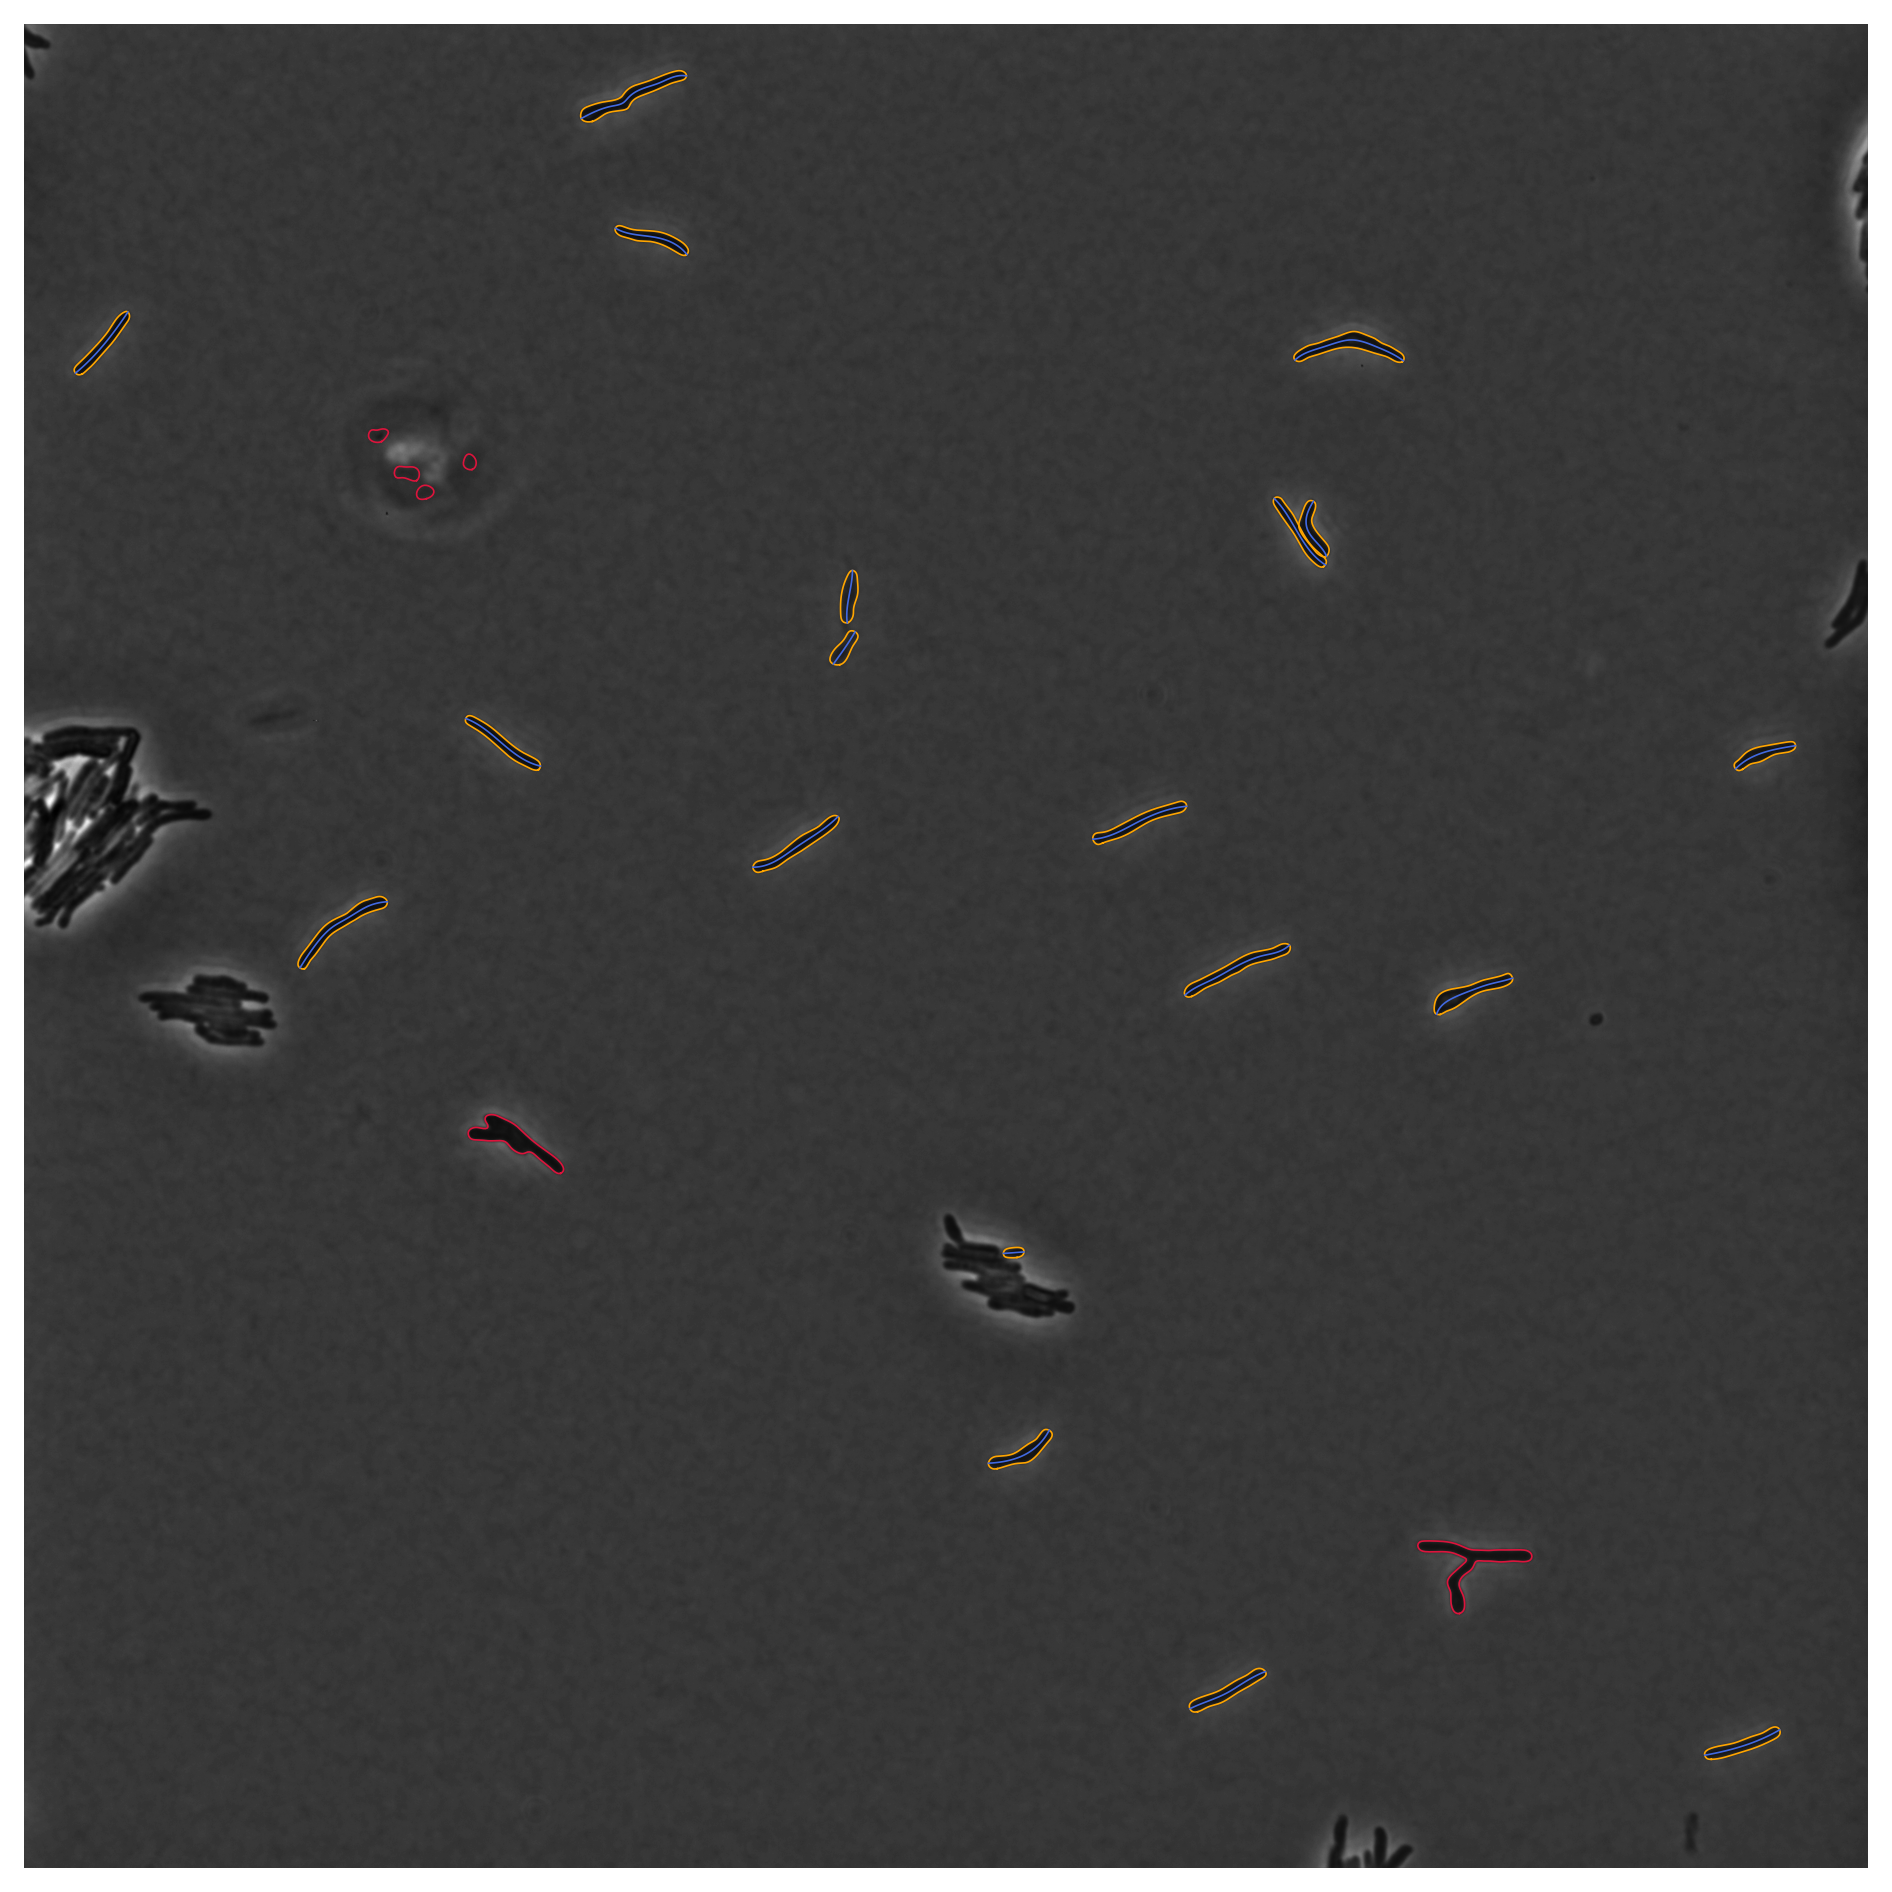

In [16]:
mo.plot.plot_segmented_image(img,show_branched=True)

### Here we select two random cells to demonstrate GEMATRIA.transform.make_thumbnail function

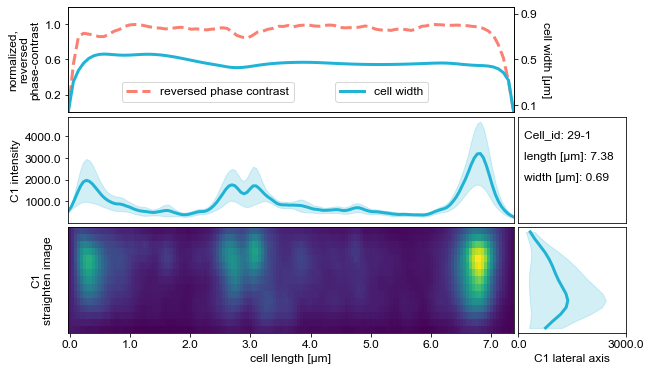

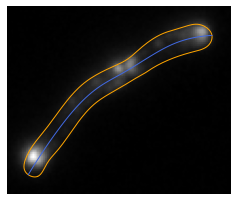

In [5]:
cell1 = cells[12]
mo.plot.cell_plot_full(cell1)
mo.plot.plot_cell(cell1,channel='C1',lw=1)

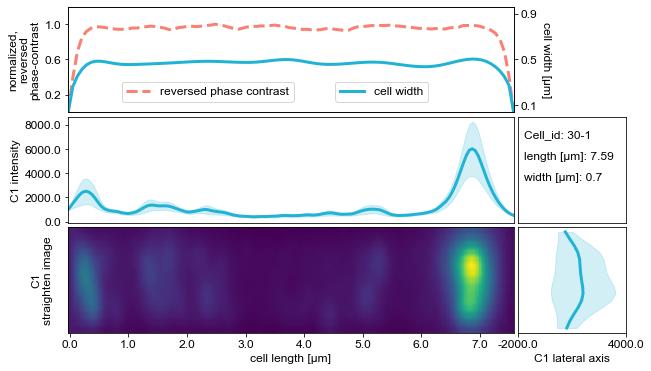

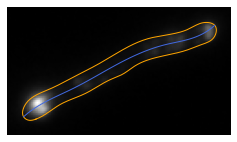

In [6]:
cell2 = cells[13]
mo.plot.cell_plot_full(cell2)
mo.plot.plot_cell(cell2,channel='C1',lw=1)

### Gematria transforms cellular data of rod-shaped bacteria in the following order: the straightened cell data, or the original intensity matrix, was firstly cut into three pieces - the two poles and the cell body. The cell body matrix is shrunk according to its cell length, where as the two cell pole matrices is resized regardless of length. The three matrices are then stiched back together to make the thumbnail representation of the intensity data.

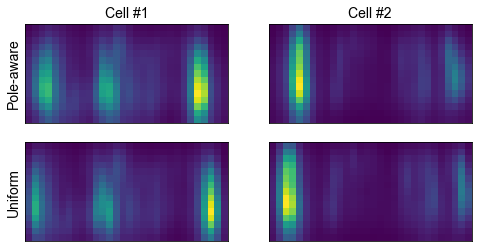

In [21]:
# compare pole-aware downsizing vs. uniform scaling

fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(8,4))

axes[0,0].imshow(gem.transform.make_thumbnail(cell1,'C1',fixed_cap_length=True,
                                            flatten=False,
                                            nrows=15,ncols=30,npole=3)[0],aspect='auto')
axes[0,0].set_ylabel('Pole-aware',fontsize=14)
axes[0,0].set_title('Cell #1',fontsize=14)
axes[1,0].imshow(gem.transform.make_thumbnail(cell1,'C1',fixed_cap_length=False,
                                            flatten=False,
                                            nrows=15,ncols=30,npole=3)[0],aspect='auto')
axes[1,0].set_ylabel('Uniform',fontsize=14)
axes[0,1].imshow(gem.transform.make_thumbnail(cell2,'C1',fixed_cap_length=True,
                                            flatten=False,
                                            nrows=15,ncols=30,npole=3)[0],aspect='auto')
axes[0,1].set_title('Cell #2',fontsize=14)
axes[1,1].imshow(gem.transform.make_thumbnail(cell2,'C1',fixed_cap_length=False,
                                            flatten=False, 
                                             nrows=15,ncols=30,npole=3)[0],aspect='auto')
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

### It is clear that direct (uniform) downscaling failed to preseve the pole-exclusion pattern of the fluorescence signals

### Users can specify the shape of the downscaled matrix as well as the span of the polar caps

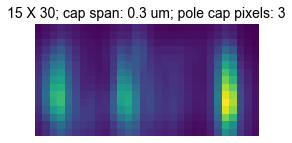

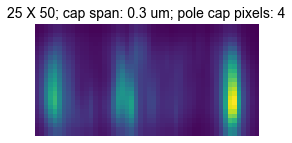

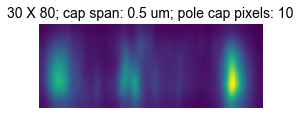

In [24]:
# 15 by 30
fig1 = plt.figure(figsize=(4,4))
nrows,ncols,pole_length,npole= 15,30,0.3,3
plt.imshow(gem.transform.make_thumbnail(cell1,'C1',fixed_cap_length=True,
                                        flatten=False,
                                        nrows=nrows,ncols=ncols,npole=npole,pole_length=pole_length)[0])
plt.title('{} X {}; cap span: {} um; pole cap pixels: {}'.format(nrows,ncols,pole_length,npole),fontsize=14)
plt.axis('off');

# 25 by 50
fig2 = plt.figure(figsize=(4,4))
nrows,ncols,pole_length,npole= 25,50,0.3,4
plt.imshow(gem.transform.make_thumbnail(cell1,'C1',fixed_cap_length=True,
                                        flatten=False,
                                        nrows=nrows,ncols=ncols,npole=npole,pole_length=pole_length)[0])
plt.title('{} X {}; cap span: {} um; pole cap pixels: {}'.format(nrows,ncols,pole_length,npole),fontsize=14)
plt.axis('off');

# 30 by 80
fig2 = plt.figure(figsize=(4,4))
nrows,ncols,pole_length,npole= 30,80,0.5,10
plt.imshow(gem.transform.make_thumbnail(cell1,'C1',fixed_cap_length=True,
                                        flatten=False,
                                        nrows=nrows,
                                        ncols=ncols,
                                        npole=npole,pole_length=pole_length)[0])
plt.title('{} X {}; cap span: {} um; pole cap pixels: {}'.format(nrows,ncols,pole_length,npole),fontsize=14)
plt.axis('off');

### Now we need to convert the Gematria transformed thumbnails of many cells (ideally over 200) into a length-binned 3-dimensional matrix. Here we used data of a published M. smegmatis strain expressing FtsQ-mGFPmut3 and FtsZ-mCherry (CB954, Wu. et. al., 2018, J. Microbiol.) to demonstrate conversion of pickled cell data to a length binned matrix. 

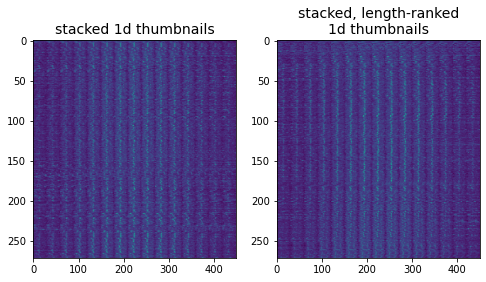

In [4]:
# link to the pickled CB954 cells
# https://www.dropbox.com/sh/27v8fovz31g7hwt/AACyHdx4ukw8vveupuQTh16ia?dl=0

# load pickled data
cb954 = mo.io.pickle_load_all_cells('/Users/jz-rolling/Downloads/CB954_001/')

# batch convert cell data to thumbnails and length list
# note that the 15X30 thumbnail is flattened to a one dimensional array of length 450
thumbnails,lengths = gem.transform.batch_make_thumbnailes(cb954,'TRITC',
                                                          nrows=15,
                                                          ncols=30,
                                                          npole=3,
                                                          pole_length=0.3,
                                                          flatten=True)

# preview thumbnails
fig,axes = plt.subplots(ncols=2,figsize=(8,4))
axes[0].imshow(thumbnails,aspect='auto')
axes[1].imshow(thumbnails[np.argsort(lengths)],aspect='auto')
axes[0].set_title('stacked 1d thumbnails',fontsize=14);
axes[1].set_title('stacked, length-ranked\n1d thumbnails',fontsize=14);

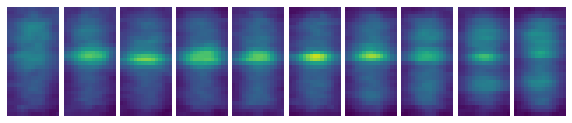

In [5]:
nrows, ncols=15,30
binned, median_lengths = gem.transform.length_based_stack(thumbnails,lengths,
                                                          n=10, # number of lengths bins
                                                          remove_extreme_perc=0.05, # ignore cells of extreme lengths
                                                          )

#visualize the transformed, binned thumbnails
fig1 = gem.plot.plot_binned_thumbnails(binned,vmin=0.5,vmax=2.5,verticle=False)

### The NMF_test module is a wrapper of sklearn's NMF function (sklearn.decomposition.NMF). Users can pass a single or a list of values to the four critical parameters: random_state, n_components (rank number), tolerance, and alpha. More detailed documentations regarding these parameters can be found in https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html.

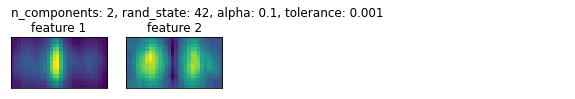

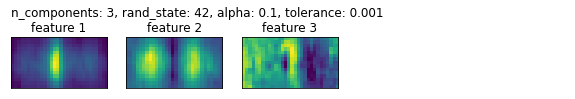

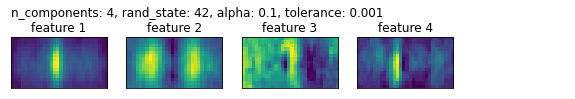

In [9]:
# test a series of NMF model and plot the basis images 
models=gem.nmf.NMF_test(binned,
                        rand_state=[42],
                        n_components=[2,3,4],
                        tol=[0.001],
                        alpha=[0.1],
                        max_iter=2000,
                        init='nndsvdar',
                        dst_folder='demo/',
                        save_plots=False,
                        save_models=False,
                        show_plots=True)

### The NMF_test function returns a list of fitted models in the format of python dictionaries. Each dictionary consists the fitted sklearn.decomposition.NMF object, the encoding and basis matrices, the reconstruction error (residual) and the parameters used to train the model. 

In [12]:
# A dictionary of fitted model is returned
print(list(models[0]))

['model', 'encoding', 'basis', 'residual', 'model_parameters']


### Here we use the two component model to plot the approximated mid-cell dynamics of FtsZ

Text(0.5, 0, 'median length [um]')

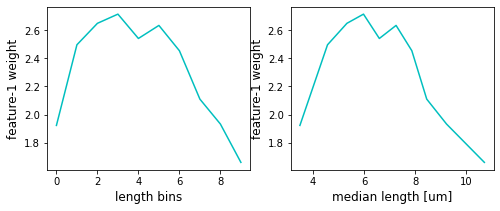

In [21]:
fig,axes=plt.subplots(ncols=2,figsize=(8,3))
axes[0].plot(models[0]['encoding'][:,0],color='c')
axes[0].set_ylabel('feature-1 weight',fontsize=12)
axes[0].set_xlabel('length bins',fontsize=12)
axes[1].plot(median_lengths,models[0]['encoding'][:,0],color='c')
axes[1].set_ylabel('feature-1 weight',fontsize=12)
axes[1].set_xlabel('median length [um]',fontsize=12)

### Now we use the precompiled, Gematria transformed MSR-Dendra dataset to train a rank-20 NMF model. The dataset consists 778 MSR_dendra entries, each are transformed into 10 length-binned matrices.

In [3]:
msr_d = np.load('demo/MSR_dendra_GEMATRIA_compiled.npy')
print(msr_d.shape)

(778, 10, 450)


### We can conviniently visuallize an entry of interest

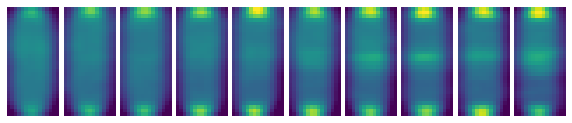

In [4]:
fig1 = gem.plot.plot_binned_thumbnails(msr_d[23],vmin=0.5,vmax=2,verticle=False)

### Min-max normalization is applied to each binned matrix before passing the data to NMF

In [5]:
from GEMATRIA.transform import min_max_normalization

# stack individual binned data to make a single master matrix for training the NMF model
nbins = 10
normalized = np.vstack([min_max_normalization(x) for x in msr_d])
print(normalized.shape)

(7780, 450)


### Now it's ready to train the NMF model, it only takes a couple of seconds with a relatively high tolerance setting.

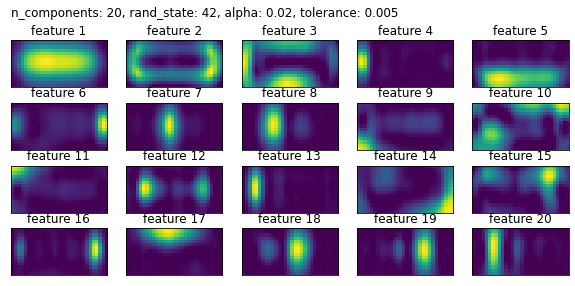

In [7]:
model = gem.nmf.NMF_test(normalized,
                         rand_state=[42],
                         n_components=[20],
                         tol=[0.005],
                         alpha=[0.02],
                         max_iter=500,
                         init='nndsvdar',
                         dst_folder='demo/',
                         save_plots=False,
                         save_models=False,
                         show_plots=True)[0]

### The NMF transformed encoding data is still large and difficult to visualize (778 X 10 X 20). Here we adapted the similarity-network-fusion (SNF) developed by Anna Goldenberg's group to smash the dataset into an unweighted composite graph.

In [18]:
import snf
import networkx as nx

reshaped = model['encoding'].reshape((msr_d.shape[0],msr_d.shape[1],20))
snf_struct = []
for i in range(10):
    snf_struct.append(reshaped[:,i,:])
    
# compute affinity 
affinity_networks = snf.make_affinity(snf_struct, metric='correlation', K=10, mu=0.5)
# SNF
fused_network = snf.snf(affinity_networks, K=10)
fused_network[np.diag_indices_from(fused_network)]=0

# convert the fully connected, composite composite graph into an unweighted, sparse graph using an arbitury cutoff

cutoff = np.percentile(fused_network,90)
indices = np.where(fused_network>=cutoff)


# render network representation using the python package networkX

g = nx.Graph()
gdata = np.zeros((len(indices[0]),2))
gdata[:,0]=indices[0]
gdata[:,1]=indices[1]
g.add_edges_from(gdata.astype(int))

final_pos = nx.layout.spring_layout(g,k=0.3,seed=24)
positions = np.zeros((len(final_pos),2))
for k,v in final_pos.items():
    positions[k]=v
positions=positions.T

### Now we can visualize the composite network representation

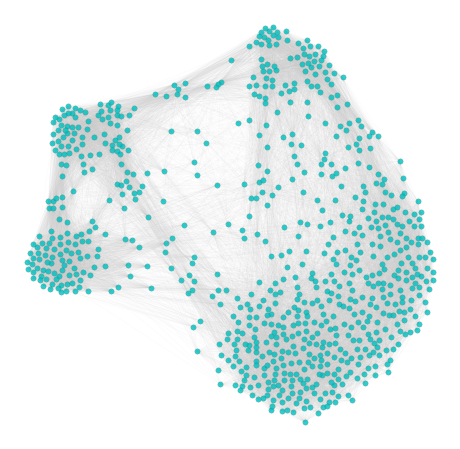

In [21]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot(111)
edges = nx.draw_networkx_edges(g,
                               pos=final_pos,
                               edge_color='silver',
                               alpha=0.05,
                               width=0.8);

plt.scatter(positions[0,:],positions[1,:],s=30,
            c='c',
            ec='black',lw=0.1,alpha=0.8)


plt.axis('off');